# AutoML Classification

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

This is a copy of the test set of the **UCI ML hand-written digits datasets** http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where each class refers to a digit.



<img src="https://www.seewald.at/img/L/digits.gif">


## Documentation Azure ML service
> https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-automated-ml

## 1. Informations

As part of the setup you have already created an Azure ML `Workspace` object. <br> For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [2]:
import azureml.core
print("Version Azure ML Service :", azureml.core.VERSION)

Version Azure ML Service : 1.2.0


In [3]:
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

In [30]:
from azureml.core import ComputeTarget, Datastore, Dataset

print("Compute Targets :")
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print("\t", compute.name, ':', compute.type)
    
print("Datastores :")
for datastore_name in ws.datastores:
    datastore = Datastore.get(ws, datastore_name)
    print("\t", datastore.name, ':', datastore.datastore_type)
    
print("Datasets :")
for dataset_name in list(ws.datasets.keys()):
    dataset = Dataset.get_by_name(ws, dataset_name)
    print("\t", dataset.name)

Compute Targets:
	 instance : ComputeInstance
Datastores:
	 teststorageserge : AzureBlob
	 azureml_globaldatasets : AzureBlob
	 workspaceblobstore : AzureBlob
	 workspacefilestore : AzureFile
Datasets:
	 dataset
	 mynewdataset
	 monfichier
	 Iris
	 mnist dataset
	 diabetes dataset


## 2. Connexion workspace Azure ML service

In [4]:
ws = Workspace.from_config()

experiment_name = 'Exemple2-automlclassificationSR'

project_folder = './sample_projects/workshop2'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

,
SDK version,1.2.0
Workspace Name,workshopAML2020
Resource Group,workshopAML2020-rg
Location,westeurope
Project Directory,./sample_projects/workshop2
Experiment Name,Exemple2-automlclassificationSR


## 3. Chargement des données

This uses scikit-learn's [load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) method.

Each datapoint is a 8x8 image of a digit.

In [5]:
from sklearn import datasets

digits = datasets.load_digits()

# Exclude the first 100 rows from training so that they can be used for test.
X_train = digits.data[100:,:]
y_train = digits.target[100:]

In [6]:
print("Taille du dataset : ", digits.data.shape)

Taille du dataset :  (1797, 64)


> On a 1797 images de 8 sur 8 pixels (=64).

### Exemples d'images :

<Figure size 432x288 with 0 Axes>

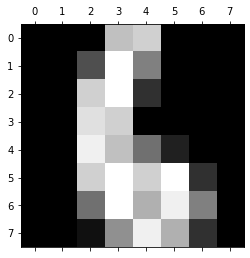

In [7]:
import matplotlib.pyplot as plt 
plt.gray() 
plt.matshow(digits.images[6]) 
plt.show() 

<Figure size 432x288 with 0 Axes>

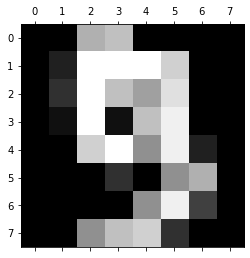

In [8]:
import matplotlib.pyplot as plt 
plt.gray() 
plt.matshow(digits.images[9]) 
plt.show() 

## 4. Configuration AutoML



In [9]:
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl2.log',
                             primary_metric = 'AUC_weighted', #the metric I want to use
                             iteration_timeout_minutes = 2, # Temps max par itération
                             experiment_timeout_minutes = 15, # Temps max pour le process AutoML
                             enable_early_stopping=True, # Sortie si pas d'amélioration de la métrique
                             iterations = 10,           # Possibilité de définir le nombre d'itérations max
                             n_cross_validations = 3,    # Nombre de validations croisées
                             verbosity = logging.INFO,
                             X = X_train, 
                             y = y_train)

WARNING - The AutoMLConfig inputs you have specified will soon be deprecated. Please use the AutoMLConfig shown in our documentation: https://aka.ms/AutoMLConfig


## 5. AutoML

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

`AUC_weighted` is the **metric** used.

In [10]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_32534e76-0d04-4639-afdd-39f8f86a7aaa

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Classes are balanced in the training data.

TYPE:         Missing values imputation
STATUS:       PASSED
DESCRIPTION:  There were no missing values found in the training data.

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no

In [11]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
Exemple2-automlclassificationSR,AutoML_32534e76-0d04-4639-afdd-39f8f86a7aaa,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


## 6. Exploration des résultats AutoML

### 6.1 Notebook Widget


In [12]:
from azureml.widgets import RunDetails
RunDetails(local_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…


### 6.2 Métriques par itération


In [14]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
AUC_macro,1.00,1.00,0.99,1.00,1.00,1.00,0.99,1.00,1.00,0.97
AUC_micro,1.00,1.00,0.99,1.00,1.00,1.00,0.99,1.00,1.00,0.97
AUC_weighted,1.00,1.00,0.99,1.00,1.00,1.00,0.99,1.00,1.00,0.97
accuracy,0.96,0.96,0.95,0.96,0.94,0.95,0.91,0.94,0.97,0.77
average_precision_score_macro,0.99,0.99,0.98,0.99,0.98,0.98,0.94,0.98,1.00,0.93
average_precision_score_micro,0.99,0.99,0.98,0.99,0.98,0.99,0.94,0.98,1.00,0.89
average_precision_score_weighted,0.99,0.99,0.98,0.99,0.98,0.98,0.94,0.98,1.00,0.93
balanced_accuracy,0.96,0.96,0.95,0.96,0.94,0.95,0.91,0.94,0.97,0.78
f1_score_macro,0.96,0.96,0.95,0.96,0.94,0.95,0.91,0.94,0.97,0.74
f1_score_micro,0.96,0.96,0.95,0.96,0.94,0.95,0.91,0.94,0.97,0.77


## 7. Récupération du meilleur modèle

In [15]:
best_run, fitted_model = local_run.get_output()
print(best_run)

Run(Experiment: Exemple2-automlclassificationSR,
Id: AutoML_32534e76-0d04-4639-afdd-39f8f86a7aaa_8,
Type: None,
Status: Completed)


In [16]:
print(fitted_model)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...        tol=0.001))]))],
               flatten_transform=None, weights=[0.4, 0.3, 0.1, 0.1, 0.1]))])


In [17]:
fitted_model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...        tol=0.001))]))],
               flatten_transform=None, weights=[0.4, 0.3, 0.1, 0.1, 0.1]))])>

In [18]:
fitted_model.steps

[('datatransformer',
  DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
          feature_sweeping_config=None, feature_sweeping_timeout=None,
          featurization_config=None, force_text_dnn=None,
          is_cross_validation=None, is_onnx_compatible=None, logger=None,
          observer=None, task=None, working_dir=None)),
 ('prefittedsoftvotingclassifier',
  PreFittedSoftVotingClassifier(classification_labels=None,
                 estimators=[('0', Pipeline(memory=None,
       steps=[('maxabsscaler', MaxAbsScaler(copy=True)), ('lightgbmclassifier', LightGBMClassifier(boosting_type='gbdt', class_weight=None,
            colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
            max_depth=-1, min_child_samples=20, ...           penalty='none', power_t=0.4444444444444444, random_state=None,
             tol=0.001))]))],
                 flatten_transform=None, weights=[0.4, 0.3, 0.1, 0.1, 0.1]))]

In [20]:
print("Métriques du meilleur modèle :")
print()
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, metric)

Métriques du meilleur modèle :

recall_score_weighted 0.9658275743456644
AUC_micro 0.9993082809988856
matthews_correlation 0.9620912591913755
log_loss 0.16725800176023933
AUC_weighted 0.9993193003206503
f1_score_micro 0.9658275743456644
precision_score_macro 0.9667019813561587
accuracy_table aml://artifactId/ExperimentRun/dcid.AutoML_32534e76-0d04-4639-afdd-39f8f86a7aaa_8/accuracy_table
balanced_accuracy 0.9661348560538404
f1_score_weighted 0.9659570031856454
average_precision_score_micro 0.9951182169098921
recall_score_micro 0.9658275743456644
average_precision_score_macro 0.9953260863590611
average_precision_score_weighted 0.9953141277099444
weighted_accuracy 0.9654283080199222
confusion_matrix aml://artifactId/ExperimentRun/dcid.AutoML_32534e76-0d04-4639-afdd-39f8f86a7aaa_8/confusion_matrix
AUC_macro 0.9993358143963968
precision_score_weighted 0.9670516324786206
accuracy 0.9658275743456644
precision_score_micro 0.9658275743456644
norm_macro_recall 0.962372062282045
recall_score_macr

### 7.1 Changement de la métrique AutoML


In [21]:
lookup_metric = "f1_score_weighted"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print("Meilleur modèle :")
print(best_run)
print()
print(fitted_model)

Meilleur modèle :
Run(Experiment: Exemple2-automlclassificationSR,
Id: AutoML_32534e76-0d04-4639-afdd-39f8f86a7aaa_8,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...        tol=0.001))]))],
               flatten_transform=None, weights=[0.4, 0.3, 0.1, 0.1, 0.1]))])


Choix d'une itération particulière :

In [22]:
iteration = 3

my_run, my_model = local_run.get_output(iteration = iteration)
print("Modèle",iteration,"eme itération :")
print(my_run)
print()
print(my_model)

Modèle 3 eme itération :
Run(Experiment: Exemple2-automlclassificationSR,
Id: AutoML_32534e76-0d04-4639-afdd-39f8f86a7aaa_3,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...1,
           penalty='none', power_t=0.4444444444444444, random_state=None,
           tol=0.001))])


## 8. Application du modèle

### 8.1 Chargement des données

In [23]:
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

### 8.2 Test
We will try to predict 2 digits and see how our model works.

4


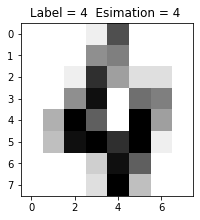

0


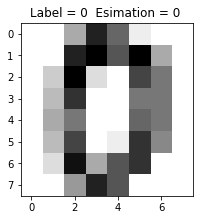

CPU times: user 478 ms, sys: 7.62 ms, total: 486 ms
Wall time: 481 ms


In [24]:
%%time
# Randomly select digits and test.
for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = "Label = %d  Esimation = %d " % (label, predicted)
    fig = plt.figure(1, figsize = (3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()

## 9. Référencement du modèle

### Meilleur modèle

In [25]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print()
print(fitted_model)
print()
print("Métriques :")
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, metric)

Run(Experiment: Exemple2-automlclassificationSR,
Id: AutoML_32534e76-0d04-4639-afdd-39f8f86a7aaa_8,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...        tol=0.001))]))],
               flatten_transform=None, weights=[0.4, 0.3, 0.1, 0.1, 0.1]))])

Métriques :
recall_score_weighted 0.9658275743456644
AUC_micro 0.9993082809988856
matthews_correlation 0.9620912591913755
log_loss 0.16725800176023933
AUC_weighted 0.9993193003206503
f1_score_micro 0.9658275743456644
precision_score_macro 0.9667019813561587
accuracy_table aml://artifactId/ExperimentRun/dcid.AutoML_32534e76-0d04-4639-afdd-39f8f86a7aaa_8/accuracy_table
balanced_accuracy 0.9661348560538404
f1_score_weighted 0.96595700

In [27]:
for step in fitted_model.named_steps:
    print(step)

datatransformer
prefittedsoftvotingclassifier


### Référencement du modèle

In [28]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', model_name='mybestmodel',
                        tags={'Training context':'Azure Auto ML'},
                        properties={'AUC': best_run_metrics['AUC_weighted'], 'Accuracy': best_run_metrics['accuracy']})

Model(workspace=Workspace.create(name='workshopAML2020', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='workshopAML2020-rg'), name=mybestmodel, id=mybestmodel:3, version=3, tags={'Training context': 'Azure Auto ML'}, properties={'AUC': '0.9993193003206503', 'Accuracy': '0.9658275743456644'})

In [29]:
# Liste des modèles référencés
for model in Model.list(ws):
    print(model.name, '- version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

mybestmodel - version = 3
	 Training context : Azure Auto ML
	 AUC : 0.9993193003206503
	 Accuracy : 0.9658275743456644


Exemple3-AutoML-Regression - version = 7
	 Training context : Azure Auto ML
	 R2 : 0.8736789106695474
	 RMSE : 0.07225365701425089


Exemple3-AutoML-Regression - version = 6
	 Training context : Azure Auto ML
	 R2 : 0.8736789106695474
	 RMSE : 0.07225365701425089


diabetes_model - version = 8
	 Training context : Pipeline


Exemple10-Modele-TensorFlow - version = 11
	 Training context : TensorFlow GPU Hyperdrive


IBM_attrition_explainer - version = 7


local_deploy_model - version = 7


Diabetes - version = 11
	 Training context : Hyperdrive
	 AUC : 0.8569106291712714
	 Accuracy : 0.7902222222222223


sklearn_regression_model.pkl - version = 13
	 area : diabetes
	 type : regression
	 format : Scikit-Learn pkl


sklearn_regression_model.pkl - version = 12
	 area : diabetes
	 type : regression
	 format : Scikit-Learn pkl


sklearn_regression_model.pkl - version = 11

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">